# 垃圾邮件识别

## 1. 准备工作

### 1.1 环境搭建

In [ ]:
# !pip install -q numpy           # 已有 numpy 则无需重复安装
# !pip install -q pandas          # 已有 pandas 则无需重复安装
# !pip install -q matplotlib      # 已有 matplotlib 则无需重复安装
# !pip install -q torch           # 已有 pytorch 则无需重复安装
# !pip install -q seaborn         # 已有 seaborn 则无需重复安装
# !pip install -q chardet         # 已有 chardet 则无需重复安装

In [ ]:
!pip install -q transformers    # huggingface 的集成工具库
!pip install -q accelerate      # 加速库
!pip install -q datasets        # 数据包
!pip install -q optuna          # 调优
!pip install -q tqdm            # 进度条

### 1.2 加载数据

In [3]:
import chardet

# 检测编码
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    return result['encoding']

In [4]:
import pandas as pd

# 原文件并非 utf-8 编码格式
df_tr = pd.read_csv('train.csv', encoding=detect_encoding('train.csv'))             # df_train
df_te = pd.read_csv('test.csv', encoding=detect_encoding('test.csv'), header=None)  # df_test

## 2. 数据分析

In [3]:
# 查看 df_tr
df_tr

,id,v1,v2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,1,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,2,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,3,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,4,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,5,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...,...
3532,3533,ham,"Sorry, I'll call later",NaN,NaN,NaN
3533,3534,ham,Good evening! How are you?,NaN,NaN,NaN
3534,3535,ham,I'm at home. Please call,NaN,NaN,NaN
3535,3536,ham,Oic cos me n my sis got no lunch today my dad ...,NaN,NaN,NaN


In [4]:
# 查看 df_te
df_te

,0,1,2,3
0,We are pleased to inform that your application...,NaN,NaN,NaN
1,What happen dear. Why you silent. I am tensed,NaN,NaN,NaN
2,"I'll get there at 3, unless you guys want me t...",NaN,NaN,NaN
3,If you are not coughing then its nothing,NaN,NaN,NaN
4,ÌÏ come lt 25 n pass to me lar,NaN,NaN,NaN
...,...,...,...,...
2030,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
2031,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
2032,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
2033,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [5]:
# 查看 df_tr.info()
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3537 entries, 0 to 3536
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          3537 non-null   int64 
 1   v1          3537 non-null   object
 2   v2          3537 non-null   object
 3   Unnamed: 3  30 non-null     object
 4   Unnamed: 4  9 non-null      object
 5   Unnamed: 5  4 non-null      object
dtypes: int64(1), object(5)
memory usage: 165.9+ KB


In [6]:
# 查看 df_te.info()
df_te.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       2035 non-null   object
 1   1       20 non-null     object
 2   2       3 non-null      object
 3   3       2 non-null      object
dtypes: object(4)
memory usage: 63.7+ KB


可以看到，数据有后三列杂列，这是由于 csv 解析逗号导致的，故合并后三列并重新规范命名

In [6]:
# 将每行的第三列之后的内容合并到第三列
df_tr['v2'] = df_tr.apply(lambda row: ','.join(map(str, filter(lambda x: pd.notna(x), row[2:]))), axis=1)
df_tr = df_tr.iloc[:, :3]

# 规范命名
df_tr = df_tr[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'content'})
df_te = df_te[[0]].rename(columns={0: 'content'})

In [108]:
# 再次查看 df_tr
df_tr

,label,content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
3532,ham,"Sorry, I'll call later"
3533,ham,Good evening! How are you?
3534,ham,I'm at home. Please call
3535,ham,Oic cos me n my sis got no lunch today my dad ...


In [109]:
# 再次查看 df_te
df_te

,content
0,We are pleased to inform that your application...
1,What happen dear. Why you silent. I am tensed
2,"I'll get there at 3, unless you guys want me t..."
3,If you are not coughing then its nothing
4,ÌÏ come lt 25 n pass to me lar
...,...
2030,This is the 2nd time we have tried 2 contact u...
2031,Will Ì_ b going to esplanade fr home?
2032,"Pity, * was in mood for that. So...any other s..."
2033,The guy did some bitching but I acted like i'd...


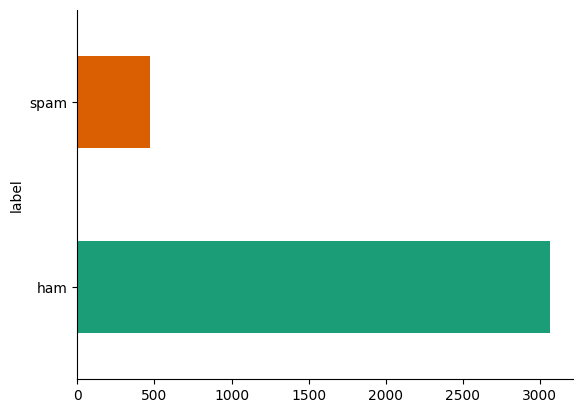

In [13]:
# df_tr 分布 - 直方图
from matplotlib import pyplot as plt
import seaborn as sns

df_tr.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

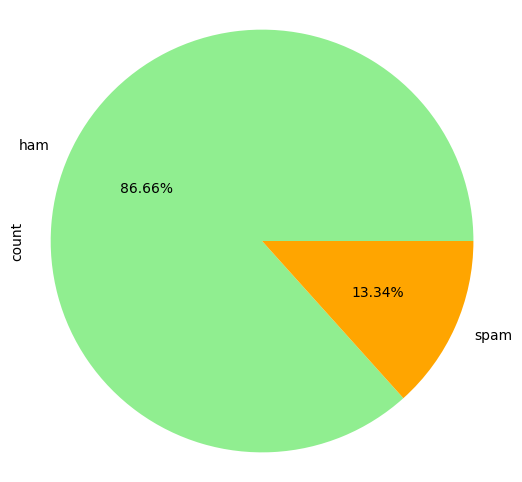

In [116]:
# df_tr 分布 - 饼图
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.set_palette(['lightgreen', 'orange'])
df_tr['label'].value_counts().plot(kind='pie', labels=['ham', 'spam'], autopct='%0.2f%%')
plt.axis('equal')
plt.show()

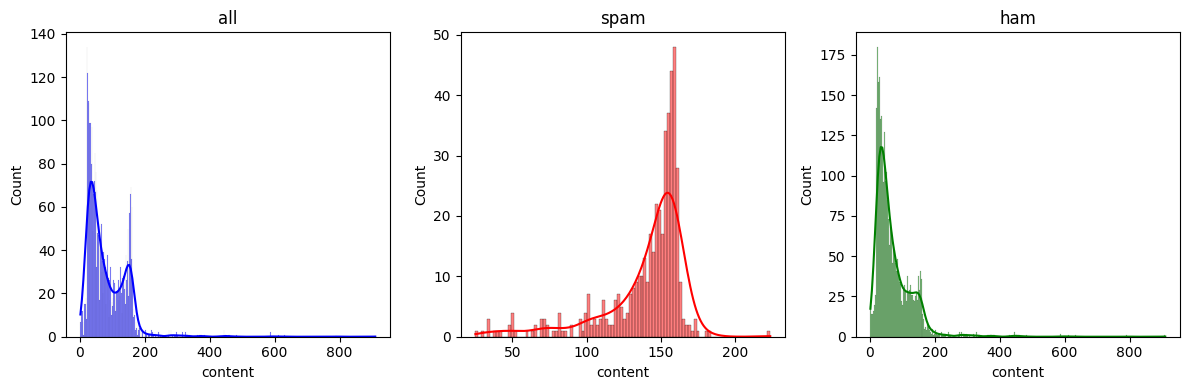

In [142]:
# 长度分布图
import seaborn as sns
import matplotlib.pyplot as plt

df_tr_len = df_tr['content'].apply(lambda x: len(x))

fig = plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title('all')
sns.histplot(df_tr_len, color='blue', label='content', bins=500, kde=True)
plt.subplot(1, 3, 2)
plt.title('spam')
sns.histplot(df_tr_len[df_tr['label']=='spam'], color='red', bins=100, kde=True)
plt.subplot(1, 3, 3)
plt.title('ham')
sns.histplot(df_tr_len[df_tr['label']=='ham'], color='green', bins=300, kde=True)

fig.tight_layout()
plt.show()

In [120]:
# 查看总长度分布数据
print(df_tr_len.describe(percentiles=[i*0.05 for i in range(20)]))

count    3537.000000
mean       81.278202
std        62.323330
min         2.000000
0%          2.000000
5%         22.000000
10%        25.000000
15%        28.000000
20%        32.000000
25%        35.000000
30%        39.000000
35%        44.000000
40%        49.000000
45%        54.000000
50%        61.000000
55%        70.000000
60%        80.000000
65%        92.000000
70%       108.000000
75%       124.000000
80%       139.000000
85%       149.000000
90%       156.000000
95%       161.000000
max       910.000000
Name: content, dtype: float64


In [121]:
# 查看尾部长度分布
print(df_tr_len.describe(percentiles=[0.9+i*0.01 for i in range(10)]))

count    3537.000000
mean       81.278202
std        62.323330
min         2.000000
50%        61.000000
90%       156.000000
91%       157.000000
92%       158.000000
93%       159.000000
94%       160.000000
95%       161.000000
96%       165.000000
97%       174.000000
98%       195.000000
99%       284.840000
max       910.000000
Name: content, dtype: float64


## 3. 分类

### 3.1 朴素贝叶斯

在 sklearn 中，共有五种朴素贝叶斯算法：

##### 1. BernoulliNB - 伯努利朴素贝叶斯
模型适用于多元伯努利分布，即每个特征都是二值变量，如果不是二值变量，该模型可以先对变量进行二值化。

在文档分类中特征是单词是否出现，如果该单词在某文件中出现了即为1，否则为0。

在文本分类中，统计词语是否出现的向量(word occurrence vectors)(而非统计词语出现次数的向量(word count vectors))可以用于训练和使用这个分类器。

BernoulliNB 可能在一些数据集上表现得更好，特别是那些更短的文档。如果时间允许，建议对两个模型都进行评估。

---
##### 2. CategoricalNB - 类朴素贝叶斯
对分类分布的数据实施分类朴素贝叶斯算法，专用于离散数据集， 它假定由索引描述的每个特征都有其自己的分类分布。

对于训练集中的每个特征 X，CNB 估计以类 y 为条件的 X 的每个特征 i 的分类分布。

样本的索引集定义为 J = 1, …, m，其中 m 为样本数。

---
##### 3. GaussianNB - 高斯朴素贝叶斯
特征变量是连续变量，符合高斯分布，比如说人的身高，物体的长度。这种模型假设特征符合高斯分布。

---
##### 4. MultinomialNB - 多项式朴素贝叶斯
特征变量是离散变量，符合多项分布，在文档分类中特征变量体现在一个单词出现的次数，或者是单词的 TF-IDF 值等。

不支持负数，所以输入变量特征的时候，不用 `StandardScaler` 进行标准化数据，可以使用 `MinMaxScaler` 进行归一化。

这个模型假设特征复合多项式分布，是一种非常典型的文本分类模型，模型内部带有平滑参数 `alpha`。

---
##### 5. ComplementNB - 补充朴素贝叶斯
是 MultinomialNB 模型的一个变种，实现了补码朴素贝叶斯(CNB)算法。

CNB 是标准多项式朴素贝叶斯(MNB)算法的一种改进，比较适用于不平衡的数据集，在文本分类上的结果通常比 MultinomialNB 模型好。

具体来说，CNB 使用来自每个类的补数的统计数据来计算模型的权重。

CNB 的发明者的研究表明，CNB 的参数估计比 MNB 的参数估计更稳定。

In [1]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB

理论上来说，MultinomialNB 和 ComplementNB 的表现应该是最好的。这五种算法我们都会进行探索。

篇幅有限，贝叶斯分类算法中，我们都将默认使用 Optuna 进行超参数调优，不再对比无调优情况。

#### 3.1.1 数据准备

In [2]:
# 从头加载数据，避免未执行前面的单元
import chardet
import pandas as pd

# 检测编码
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    return result['encoding']

# 原文件并非 utf-8 编码格式
df_tr = pd.read_csv('train.csv', encoding=detect_encoding('train.csv'))             # df_train
df_te = pd.read_csv('test.csv', encoding=detect_encoding('test.csv'), header=None)  # df_test

# 将每行的第三列之后的内容合并到第三列
df_tr['v2'] = df_tr.apply(lambda row: ','.join(map(str, filter(lambda x: pd.notna(x), row[2:]))), axis=1)
df_tr = df_tr.iloc[:, :3]

# 规范命名
df_tr = df_tr[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'content'})
df_te = df_te[[0]].rename(columns={0: 'content'})

In [3]:
# 数据划分
x = df_tr['content']                                            # 内容
y = df_tr['label'].apply(lambda x: 1 if x == 'spam' else 0)     # 标签
x.shape, y.shape

((3537,), (3537,))

In [4]:
# 划分训练集和验证集
# 8 : 2
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3407)
x_train.shape, x_test.shape

((2829,), (708,))

In [5]:
# 需要预测的真实测试集
real_x = df_te['content']
real_x.shape

(2035,)

#### 3.1.2 分类

In [17]:
# 用于将文本数据转换为词袋模型的表示形式，即将文本转换为词频矩阵
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
x_train_cnt = cv.fit_transform(x_train.values)
x_test_cnt = cv.transform(x_test.values)
real_x_cnt = cv.transform(real_x.values)

x_train_cnt.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [7]:
import optuna.logging

# 设置 Optuna 的日志级别为 WARNING，即 WARNING 以上才输出
optuna.logging.set_verbosity(optuna.logging.WARNING)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### 3.1.2.1 BernoulliNB

In [18]:
import optuna

def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-10, 1.0)
    model = BernoulliNB(alpha=alpha)
    model.fit(x_train_cnt, y_train)
    return model.score(x_test_cnt, y_test)

# 创建Optuna优化对象
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

# 输出最佳超参数取值
best_alpha = study.best_params['alpha']
best_test_value = study.best_value
print("Best alpha:", best_alpha)
print("Best test value: ", best_test_value)

# 用最佳超参数训练并预测
best_mnb = BernoulliNB(alpha=best_alpha)
best_mnb.fit(x_train_cnt, y_train)
mnb_pred = best_mnb.predict(real_x_cnt)

# 输出
# ...

Best alpha: 0.04664517822569222
Best test value:  0.9901129943502824


##### 3.1.2.2 CategoricalNB

In [ ]:
import optuna

def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-10, 1.0)
    model = CategoricalNB(alpha=alpha)
    model.fit(x_train_cnt.toarray(), y_train)
    return model.score(x_test_cnt.toarray(), y_test)

# 创建Optuna优化对象
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

# 输出最佳超参数取值
best_alpha = study.best_params['alpha']
best_test_value = study.best_value
print("Best alpha:", best_alpha)
print("Best test value: ", best_test_value)

# 用最佳超参数训练并预测
best_mnb = CategoricalNB(alpha=best_alpha)
best_mnb.fit(x_train_cnt.toarray(), y_train)
mnb_pred = best_mnb.predict(real_x_cnt.toarray())

# 输出
# ...

##### 3.1.2.3 GaussianNB

In [13]:
import optuna

def objective(trial):
    var_smoothing = trial.suggest_float('var_smoothing', 1e-10, 1.0)
    model = GaussianNB(var_smoothing=var_smoothing)
    model.fit(x_train_cnt.toarray(), y_train)
    return model.score(x_test_cnt.toarray(), y_test)

# 创建Optuna优化对象
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 输出最佳超参数取值
best_var_smoothing = study.best_params['var_smoothing']
best_test_value = study.best_value
print("Best var_smoothing:", best_alpha)
print("Best test value: ", best_test_value)

# 用最佳超参数训练并预测
best_mnb = GaussianNB(var_smoothing=best_var_smoothing)
best_mnb.fit(x_train_cnt.toarray(), y_train)
mnb_pred = best_mnb.predict(real_x_cnt.toarray())

# 输出
# ...

Best var_smoothing: 0.3163251169367887
Best test value:  0.9901129943502824


##### 3.1.2.4 MultinomialNB

In [14]:
import optuna

def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-10, 1.0)
    model = MultinomialNB(alpha=alpha)
    model.fit(x_train_cnt, y_train)
    return model.score(x_test_cnt, y_test)

# 创建Optuna优化对象
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

# 输出最佳超参数取值
best_alpha = study.best_params['alpha']
best_test_value = study.best_value
print("Best alpha:", best_alpha)
print("Best test value: ", best_test_value)

# 用最佳超参数训练并预测
best_mnb = MultinomialNB(alpha=best_alpha)
best_mnb.fit(x_train_cnt, y_train)
mnb_pred = best_mnb.predict(real_x_cnt)

# 输出
# ...

Best alpha: 0.7932421694220678
Best test value:  0.9887005649717514


##### 3.1.2.5 ComplementNB

In [15]:
import optuna

def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-10, 1.0)
    model = ComplementNB(alpha=alpha)
    model.fit(x_train_cnt, y_train)
    return model.score(x_test_cnt, y_test)

# 创建Optuna优化对象
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

# 输出最佳超参数取值
best_alpha = study.best_params['alpha']
best_test_value = study.best_value
print("Best alpha:", best_alpha)
print("Best test value: ", best_test_value)

# 用最佳超参数训练并预测
best_mnb = ComplementNB(alpha=best_alpha)
best_mnb.fit(x_train_cnt, y_train)
mnb_pred = best_mnb.predict(real_x_cnt)

# 输出
# ...

Best alpha: 0.25508267533275286
Best test value:  0.9901129943502824


### 3.2 LSTM

#### 3.2.1 数据准备

In [17]:
# 从头加载数据，避免未执行前面的单元
import chardet
import pandas as pd

# 检测编码
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    return result['encoding']

# 原文件并非 utf-8 编码格式
df_tr = pd.read_csv('train.csv', encoding=detect_encoding('train.csv'))             # df_train
df_te = pd.read_csv('test.csv', encoding=detect_encoding('test.csv'), header=None)  # df_test

# 将每行的第三列之后的内容合并到第三列
df_tr['v2'] = df_tr.apply(lambda row: ','.join(map(str, filter(lambda x: pd.notna(x), row[2:]))), axis=1)
df_tr = df_tr.iloc[:, :3]

# 规范命名
df_tr = df_tr[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'content'})
df_te = df_te[[0]].rename(columns={0: 'content'})

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# 数据预处理
X_train, X_val, y_train, y_val = train_test_split(df_tr['content'], df_tr['label'], test_size=0.2, random_state=42)

# 使用CountVectorizer将文本转换为词袋模型
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

# 转换为PyTorch Tensor
X_train_tensor = torch.tensor(X_train_vec.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.map({'ham': 0, 'spam': 1}).values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_vec.toarray(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.map({'ham': 0, 'spam': 1}).values, dtype=torch.float32)

# 定义数据集类
class SpamDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# 创建数据加载器
train_dataset = SpamDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [19]:
# 定义LSTM模型
class SpamClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SpamClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x.unsqueeze(1))  # 添加一个维度
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

In [20]:
# 初始化模型、损失函数和优化器
input_size = X_train_tensor.shape[1]
hidden_size = 128
output_size = 1
model = SpamClassifier(input_size, hidden_size, output_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}')


Epoch 1/10: 100%|██████████| 45/45 [00:01<00:00, 39.75it/s]


Epoch 1/10, Loss: 0.532495645682017



Epoch 2/10: 100%|██████████| 45/45 [00:01<00:00, 40.15it/s]


Epoch 2/10, Loss: 0.237653453151385



Epoch 3/10: 100%|██████████| 45/45 [00:01<00:00, 40.88it/s]


Epoch 3/10, Loss: 0.09333996238807837



Epoch 4/10: 100%|██████████| 45/45 [00:01<00:00, 40.29it/s]


Epoch 4/10, Loss: 0.04695290985206763



Epoch 5/10: 100%|██████████| 45/45 [00:01<00:00, 40.04it/s]


Epoch 5/10, Loss: 0.02688459021349748



Epoch 6/10: 100%|██████████| 45/45 [00:01<00:00, 40.11it/s]


Epoch 6/10, Loss: 0.015931633156206874



Epoch 7/10: 100%|██████████| 45/45 [00:01<00:00, 40.55it/s]


Epoch 7/10, Loss: 0.00993757338470055



Epoch 8/10: 100%|██████████| 45/45 [00:01<00:00, 40.08it/s]


Epoch 8/10, Loss: 0.007307203729740448



Epoch 9/10: 100%|██████████| 45/45 [00:01<00:00, 39.49it/s]


Epoch 9/10, Loss: 0.004791276829524173



Epoch 10/10: 100%|██████████| 45/45 [00:01<00:00, 40.49it/s]

Epoch 10/10, Loss: 0.0036608873271486825


In [22]:
# 在验证集上评估模型
model.eval()
with torch.no_grad():
    val_output = model(X_val_tensor)
    val_loss = criterion(val_output.squeeze(), y_val_tensor)
    val_preds = (val_output.squeeze() >= 0.5).float()
    accuracy = torch.sum(val_preds == y_val_tensor).item() / len(y_val_tensor)

print(f'Validation Loss: {val_loss.item()}, Accuracy: {accuracy}')


Validation Loss: 0.09964179992675781, Accuracy: 0.9788135593220338


#### 3.2.3 optuna调优

In [23]:
import optuna

def objective(trial):
    # 定义超参数搜索空间
    hidden_size = trial.suggest_int('hidden_size', 32, 256)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    # 初始化模型
    model = SpamClassifier(input_size, hidden_size, output_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 训练模型
    num_epochs = 5  # 可以根据实际情况调整
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output.squeeze(), batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # 在每个epoch结束后记录损失
        trial.report(total_loss, epoch)

        # 判断是否应该提前停止训练
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 返回验证集上的准确度作为目标值
    model.eval()
    with torch.no_grad():
        val_output = model(X_val_tensor)
        val_loss = criterion(val_output.squeeze(), y_val_tensor)
        val_preds = (val_output.squeeze() >= 0.5).float()
        accuracy = torch.sum(val_preds == y_val_tensor).item() / len(y_val_tensor)

    return accuracy

# 创建Optuna试验对象
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # 设置n_trials为你希望尝试的不同超参数组合的次数

# 打印最佳超参数和目标值
print('Best trial:')
trial = study.best_trial

print('Value: {}'.format(trial.value))
print('Params: ')
for key, value in trial.params.items():
    print('{}: {}'.format(key, value))


[I 2023-12-09 13:11:42,432] A new study created in memory with name: no-name-e4622bb3-b9ff-4518-9e36-f4576fccb3d4
C:\Users\99702\AppData\Local\Temp\ipykernel_7956\4180536850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2023-12-09 13:11:47,858] Trial 0 finished with value: 0.8742937853107344 and parameters: {'hidden_size': 109, 'learning_rate': 1.1996277208846616e-05}. Best is trial 0 with value: 0.8742937853107344.
[I 2023-12-09 13:11:53,705] Trial 1 finished with value: 0.9774011299435028 and parameters: {'hidden_size': 137, 'learning_rate': 0.005965976500581366}. Best is trial 1 with value: 0.9774011299435028.
[I 2023-12-09 13:11:57,964] Trial 2 finished with value: 0.8912429378531074 and parameters: {'hidden_size': 97, 'learning_rate': 3.33018300

Best trial:
Value: 0.980225988700565
Params: 
hidden_size: 57
learning_rate: 0.003020475950659399


#### 3.2.4 输出

In [24]:
# 使用最佳超参数重新训练模型
best_hidden_size = study.best_params['hidden_size']
best_learning_rate = study.best_params['learning_rate']

# 初始化模型
best_model = SpamClassifier(input_size, best_hidden_size, output_size)
best_optimizer = optim.Adam(best_model.parameters(), lr=best_learning_rate)
best_criterion = nn.BCELoss()

# 训练模型
num_epochs = 10  # 可以根据实际情况调整
for epoch in range(num_epochs):
    best_model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        best_optimizer.zero_grad()
        output = best_model(batch_X)
        loss = best_criterion(output.squeeze(), batch_y)
        loss.backward()
        best_optimizer.step()
        total_loss += loss.item()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}')

Epoch 1/10, Loss: 0.4193185647328695
Epoch 2/10, Loss: 0.08081443049013615
Epoch 3/10, Loss: 0.027794528814653555
Epoch 4/10, Loss: 0.010755651630461216
Epoch 5/10, Loss: 0.004661946516070101
Epoch 6/10, Loss: 0.0028451162649111615
Epoch 7/10, Loss: 0.0019019572193630868
Epoch 8/10, Loss: 0.0015047467559472555
Epoch 9/10, Loss: 0.0010434836362643789
Epoch 10/10, Loss: 0.0008183863486111578


In [25]:
# 需要预测的真实测试集
real_x = df_te['content']
real_x.shape

# 在测试集上进行预测
real_x_vec = vectorizer.transform(real_x)
real_x_tensor = torch.tensor(real_x_vec.toarray(), dtype=torch.float32)

best_model.eval()
with torch.no_grad():
    test_output = best_model(real_x_tensor)
    test_preds = (test_output.squeeze() >= 0.5).float()

# 将预测结果转换为 DataFrame
df_result = pd.DataFrame({'content': real_x, 'prediction': test_preds.numpy()})

# 如果 prediction 列的值为 1，则代表 spam；否则，为 ham
df_result['label'] = df_result['prediction'].apply(lambda x: 'spam' if x == 1 else 'ham')
df_result = df_result[['content', 'label']]

# 查看预测结果
print(df_result.head())

with open('submission_lstm.txt', 'w', encoding='utf-8') as f:
    for res in df_result['label']:
        f.write(res + '\n')
    # f.write('\n'.join(pred_list_lstm))

                                             content label
0  We are pleased to inform that your application...   ham
1      What happen dear. Why you silent. I am tensed   ham
2  I'll get there at 3, unless you guys want me t...   ham
3           If you are not coughing then its nothing   ham
4                     ÌÏ come lt 25 n pass to me lar   ham


### 3.2 Bert

#### 3.2.1 数据集准备

In [4]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'     # Apple M 系列芯片可选 mps 加速
model_path = 'distilbert-base-uncased'                      # 可以指定本地路径
torch.manual_seed(3407)                                     # 随机种子

In [5]:
# 再次声明检测编码函数
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    return result['encoding']

In [6]:
import chardet
import pandas as pd
from torch.utils.data import Dataset

# 自定义数据集
class SpamHamDataset(Dataset):
    def __init__(self, file_path) -> None:
        super().__init__()
        self.data = pd.read_csv(file_path, encoding=detect_encoding(file_path))
        self.data = self.data[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'content'})

    def __getitem__(self, index):
        return self.data.iloc[index]['content'], self.data.iloc[index]['label']

    def __len__(self):
        return len(self.data)

In [7]:
ds = SpamHamDataset('train.csv')

# 查看
for i in range(5):
    print(ds[i])

('Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...', 'ham')
('Ok lar... Joking wif u oni...', 'ham')
("Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's", 'spam')
('U dun say so early hor... U c already then say...', 'ham')
("Nah I don't think he goes to usf, he lives around here though", 'ham')


In [8]:
# 划分训练集，验证集
# 8 : 2
from torch.utils.data import random_split

tr_ds, val_ds = random_split(ds, lengths=[0.8, 0.2])    # train_dataset, valid_dataset
len(tr_ds), len(val_ds)

(2830, 707)

#### 3.2.2 模型准备

In [14]:
import torch
from transformers import AutoTokenizer

# 分词器
tokenizer = AutoTokenizer.from_pretrained(
    model_path,
    use_fast=True,  # 快速分词器
)

# Collator
def collate_fn(batch):
    contents, labels = [], []
    for item in batch:
        contents.append(item[0])
        labels.append(1 if item[1] == 'spam' else 0)
    # max_length 是前面的 0.99 分位点
    inputs = tokenizer(contents, max_length=288, padding='max_length', truncation=True, return_tensors='pt')
    inputs['labels'] = torch.tensor(labels)
    return inputs

In [15]:
# DataLoader
from torch.utils.data import DataLoader

tr_loader = DataLoader(tr_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [16]:
# 查看一下
next(enumerate(tr_loader))[1]

{'input_ids': tensor([[  101,  3449,  4135,  ...,     0,     0,     0],
        [  101,  2074,  8025,  ...,     0,     0,     0],
        [  101,  2053,  2053,  ...,     0,     0,     0],
        ...,
        [  101,  7929,  1012,  ...,     0,     0,     0],
        [  101,  2027,  2207,  ...,     0,     0,     0],
        [  101, 11948,  2072,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])}

In [17]:
from tqdm import tqdm

# 评估函数
def evaluate(model, dataset, loader):
    model.eval()
    acc_num = 0

    with torch.inference_mode():
        for batch in tqdm(loader):
            if device == 'cuda':
                batch = {k: v.cuda() for k, v in batch.items()}
            output = model(**batch)
            pred = torch.argmax(output.logits, dim=-1)
            acc_num += (pred.long() == batch['labels'].long()).float().sum()

    return acc_num / len(dataset)

In [18]:
from tqdm import tqdm
from copy import deepcopy

# 训练函数
def train(model, optimizer, num_epochs=3, logging_steps=50):
    global_step = 0
    model.to(device)

    for epoch in range(num_epochs):
        print(f"current epoch: {epoch + 1} {'=' * 80}", flush=True)
        model.train()

        for batch in tqdm(tr_loader):
            if device == 'cuda':
                batch = {k: v.cuda() for k, v in batch.items()}
            optimizer.zero_grad()
            output = model(**batch)
            output.loss.backward()
            optimizer.step()

            if (global_step + 1) % logging_steps == 0:
                print(f'\nsteps: {global_step}, loss: {output.loss.item()}', flush=True)
            global_step += 1

        # 每个 epoch 后都进行评估
        acc = evaluate(model, val_ds, val_loader)
        print(f'\naccuracy: {acc}', flush=True)

#### 3.2.3 未调参

In [33]:
num_epochs = 3
logging_steps = 50
lr = 2e-5

In [30]:
import torch.optim as optim

# 优化器选用 AdamW
optimizer = optim.AdamW(model.parameters(), lr=lr)

In [12]:
from transformers import AutoModelForSequenceClassification

# 加载 distil-bert-cased 模型
model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
# 开始训练
train(model, optimizer, num_epochs, logging_steps)

current epoch: 1 ================================================================================


 55%|█████▌    | 49/89 [00:21<00:15,  2.60it/s]

steps: 49, loss: 0.04640495404601097


100%|██████████| 12/12 [00:03<00:00,  3.46it/s]

accuracy: 0.9915134310722351
current epoch: 2 ================================================================================



 11%|█         | 10/89 [00:03<00:30,  2.57it/s]

steps: 99, loss: 0.009304738603532314


 67%|██████▋   | 60/89 [00:23<00:11,  2.48it/s]

steps: 149, loss: 0.041676074266433716


100%|██████████| 12/12 [00:03<00:00,  3.37it/s]

accuracy: 0.9929279088973999
current epoch: 3 ================================================================================



 24%|██▎       | 21/89 [00:08<00:27,  2.45it/s]

steps: 199, loss: 0.14585527777671814


 80%|███████▉  | 71/89 [00:29<00:07,  2.38it/s]

steps: 249, loss: 0.0033556544221937656


100%|██████████| 12/12 [00:03<00:00,  3.24it/s]

accuracy: 0.9929279088973999


#### 3.2.4 Optuna 自动调参

In [19]:
# 定义目标函数，供 Optuna 调用
import torch.optim as optim
from transformers import AutoModelForSequenceClassification

logging_steps = 100

def objective(trial):
    # 定义超参数搜索空间
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-3, 1e-1, log=True)
    eps = trial.suggest_float('eps', 1e-9, 1e-6, log=True)
    params = {
        'lr': lr,
        'weight_decay': weight_decay,
        'eps': eps,
    }

    model = AutoModelForSequenceClassification.from_pretrained(
        model_path,
    )
    optimizer = optim.AdamW(model.parameters(), **params)

    global_step = 0
    model.to(device)

    model.train()
    for batch in tqdm(tr_loader):
        if device == 'cuda':
            batch = {k: v.cuda() for k, v in batch.items()}
        optimizer.zero_grad()
        output = model(**batch)
        output.loss.backward()
        optimizer.step()

        if (global_step + 1) % logging_steps == 0:
            print(f'\nsteps: {global_step}, loss: {output.loss.item()}', flush=True)
        global_step += 1

    # 进行评估
    acc = evaluate(model, val_ds, val_loader)
    print(f'\naccuracy: {acc}', flush=True)

    return acc  # Optuna 追求最大化目标

In [20]:
import optuna

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2023-11-16 23:42:01,852] A new study created in memory with name: no-name-b22aba35-a556-4091-ae4b-2581b7d27cb1
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


accuracy: 0.984441339969635



[I 2023-11-16 23:43:11,093] Trial 0 finished with value: 0.984441339969635 and parameters: {'lr': 0.00016611072831035025, 'weight_decay': 0.005146360255320083, 'eps': 2.8255957301958363e-08}. Best is trial 0 with value: 0.984441339969635.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.76it/s]


accuracy: 0.984441339969635



[I 2023-11-16 23:44:25,560] Trial 1 finished with value: 0.984441339969635 and parameters: {'lr': 0.00013983639078775833, 'weight_decay': 0.004011445474443229, 'eps': 2.820395639014507e-07}. Best is trial 0 with value: 0.984441339969635.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


accuracy: 0.9886845946311951



[I 2023-11-16 23:45:42,783] Trial 2 finished with value: 0.9886845946311951 and parameters: {'lr': 2.157384563749783e-05, 'weight_decay': 0.025599128679594668, 'eps': 1.5378295332367747e-09}. Best is trial 2 with value: 0.9886845946311951.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.89it/s]


accuracy: 0.8656294345855713



[I 2023-11-16 23:46:59,695] Trial 3 finished with value: 0.8656294345855713 and parameters: {'lr': 0.00041837719915014055, 'weight_decay': 0.07679022794975604, 'eps': 2.203502601160044e-07}. Best is trial 2 with value: 0.9886845946311951.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.92it/s]


accuracy: 0.8656294345855713



[I 2023-11-16 23:48:15,949] Trial 4 finished with value: 0.8656294345855713 and parameters: {'lr': 0.0014284155710492207, 'weight_decay': 0.09638230584206718, 'eps': 1.038494037027689e-09}. Best is trial 2 with value: 0.9886845946311951.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.99it/s]


accuracy: 0.8656294345855713



[I 2023-11-16 23:49:31,954] Trial 5 finished with value: 0.8656294345855713 and parameters: {'lr': 0.005757305150872561, 'weight_decay': 0.08119435916711741, 'eps': 5.8421651033932514e-08}. Best is trial 2 with value: 0.9886845946311951.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


accuracy: 0.9886845946311951



[I 2023-11-16 23:50:49,244] Trial 6 finished with value: 0.9886845946311951 and parameters: {'lr': 1.6707795368737402e-05, 'weight_decay': 0.011636356846059197, 'eps': 8.40671059297352e-07}. Best is trial 2 with value: 0.9886845946311951.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


accuracy: 0.987270176410675



[I 2023-11-16 23:52:06,381] Trial 7 finished with value: 0.987270176410675 and parameters: {'lr': 7.287649970314632e-05, 'weight_decay': 0.002504036570589686, 'eps': 1.9684389039538736e-09}. Best is trial 2 with value: 0.9886845946311951.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


accuracy: 0.9886845946311951



[I 2023-11-16 23:53:23,772] Trial 8 finished with value: 0.9886845946311951 and parameters: {'lr': 4.698519126754657e-05, 'weight_decay': 0.0019851300734651726, 'eps': 1.7190352884527314e-08}. Best is trial 2 with value: 0.9886845946311951.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


accuracy: 0.984441339969635



[I 2023-11-16 23:54:41,294] Trial 9 finished with value: 0.984441339969635 and parameters: {'lr': 0.0001190169191108775, 'weight_decay': 0.0014087903774218037, 'eps': 2.2527909747816582e-08}. Best is trial 2 with value: 0.9886845946311951.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


accuracy: 0.9886845946311951



[I 2023-11-16 23:55:58,572] Trial 10 finished with value: 0.9886845946311951 and parameters: {'lr': 1.4972070357100176e-05, 'weight_decay': 0.021426248622943678, 'eps': 3.466744971101538e-09}. Best is trial 2 with value: 0.9886845946311951.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


accuracy: 0.9886845946311951



[I 2023-11-16 23:57:15,932] Trial 11 finished with value: 0.9886845946311951 and parameters: {'lr': 1.069761928337441e-05, 'weight_decay': 0.012939833128570114, 'eps': 6.069951717165009e-07}. Best is trial 2 with value: 0.9886845946311951.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


accuracy: 0.9929279088973999



[I 2023-11-16 23:58:33,239] Trial 12 finished with value: 0.9929279088973999 and parameters: {'lr': 3.085411381943491e-05, 'weight_decay': 0.022923593042419334, 'eps': 8.254221467789509e-07}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


accuracy: 0.9900990128517151



[I 2023-11-16 23:59:50,489] Trial 13 finished with value: 0.9900990128517151 and parameters: {'lr': 3.9397932126931857e-05, 'weight_decay': 0.03037805931261226, 'eps': 6.030630171116984e-09}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


accuracy: 0.985855758190155



[I 2023-11-17 00:01:07,836] Trial 14 finished with value: 0.985855758190155 and parameters: {'lr': 3.687597971872973e-05, 'weight_decay': 0.03602277965900572, 'eps': 7.035292257605217e-09}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


accuracy: 0.9886845946311951



[I 2023-11-17 00:02:25,256] Trial 15 finished with value: 0.9886845946311951 and parameters: {'lr': 3.8817872936688935e-05, 'weight_decay': 0.03725650757622905, 'eps': 8.13023472889859e-08}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.84it/s]


accuracy: 0.9816124439239502



[I 2023-11-17 00:03:42,396] Trial 16 finished with value: 0.9816124439239502 and parameters: {'lr': 0.00032673942897722423, 'weight_decay': 0.006958465399061996, 'eps': 6.961054412334849e-09}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


accuracy: 0.9915134310722351



[I 2023-11-17 00:04:59,559] Trial 17 finished with value: 0.9915134310722351 and parameters: {'lr': 3.182563622164694e-05, 'weight_decay': 0.01612614193130695, 'eps': 1.1526884969711229e-07}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


accuracy: 0.9886845946311951



[I 2023-11-17 00:06:16,838] Trial 18 finished with value: 0.9886845946311951 and parameters: {'lr': 7.902913706568533e-05, 'weight_decay': 0.017685467364202748, 'eps': 9.758031384871458e-07}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


accuracy: 0.9886845946311951



[I 2023-11-17 00:07:34,431] Trial 19 finished with value: 0.9886845946311951 and parameters: {'lr': 2.0710747826541462e-05, 'weight_decay': 0.008459531787750748, 'eps': 1.618914790574783e-07}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


accuracy: 0.9900990128517151



[I 2023-11-17 00:08:52,095] Trial 20 finished with value: 0.9900990128517151 and parameters: {'lr': 1.009698212200476e-05, 'weight_decay': 0.013560761279730134, 'eps': 3.7822555260459256e-07}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


accuracy: 0.9915134310722351



[I 2023-11-17 00:10:09,559] Trial 21 finished with value: 0.9915134310722351 and parameters: {'lr': 3.208547968527233e-05, 'weight_decay': 0.033492108404883085, 'eps': 7.258038025003091e-08}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


accuracy: 0.9787836074829102



[I 2023-11-17 00:11:26,916] Trial 22 finished with value: 0.9787836074829102 and parameters: {'lr': 2.9313648796329506e-05, 'weight_decay': 0.049592510299943805, 'eps': 8.349902684229545e-08}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


accuracy: 0.9915134310722351



[I 2023-11-17 00:12:44,260] Trial 23 finished with value: 0.9915134310722351 and parameters: {'lr': 6.211497892557287e-05, 'weight_decay': 0.019145396278973315, 'eps': 1.247198668459966e-07}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


accuracy: 0.9915134310722351



[I 2023-11-17 00:14:01,745] Trial 24 finished with value: 0.9915134310722351 and parameters: {'lr': 2.398069666149199e-05, 'weight_decay': 0.045139274204989, 'eps': 3.785923928993646e-07}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


accuracy: 0.9886845946311951



[I 2023-11-17 00:15:19,141] Trial 25 finished with value: 0.9886845946311951 and parameters: {'lr': 6.928384907260053e-05, 'weight_decay': 0.016835872682871816, 'eps': 1.5884611366136e-07}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


accuracy: 0.987270176410675



[I 2023-11-17 00:16:36,312] Trial 26 finished with value: 0.987270176410675 and parameters: {'lr': 2.801730536629931e-05, 'weight_decay': 0.0267930794067874, 'eps': 4.313066825824891e-08}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


accuracy: 0.9886845946311951



[I 2023-11-17 00:17:53,697] Trial 27 finished with value: 0.9886845946311951 and parameters: {'lr': 1.668528921394491e-05, 'weight_decay': 0.055420374188570126, 'eps': 5.113611088506606e-07}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


accuracy: 0.9702970385551453



[I 2023-11-17 00:19:10,714] Trial 28 finished with value: 0.9702970385551453 and parameters: {'lr': 0.00021295795686374528, 'weight_decay': 0.010403699776741167, 'eps': 2.448773248435271e-07}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


accuracy: 0.987270176410675



[I 2023-11-17 00:20:27,935] Trial 29 finished with value: 0.987270176410675 and parameters: {'lr': 0.00011024059254273973, 'weight_decay': 0.024761899098798067, 'eps': 3.586156661588314e-08}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


accuracy: 0.9915134310722351



[I 2023-11-17 00:21:45,258] Trial 30 finished with value: 0.9915134310722351 and parameters: {'lr': 4.7246592545428835e-05, 'weight_decay': 0.015276356145107134, 'eps': 1.0614204458750834e-07}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


accuracy: 0.9674682021141052



[I 2023-11-17 00:23:02,961] Trial 31 finished with value: 0.9674682021141052 and parameters: {'lr': 5.0589828877234616e-05, 'weight_decay': 0.018883258346354393, 'eps': 1.4058063331568052e-07}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


accuracy: 0.9773691892623901



[I 2023-11-17 00:24:20,776] Trial 32 finished with value: 0.9773691892623901 and parameters: {'lr': 6.499437535053576e-05, 'weight_decay': 0.018648298902757064, 'eps': 7.203428684138624e-08}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


accuracy: 0.9816124439239502



[I 2023-11-17 00:25:38,605] Trial 33 finished with value: 0.9816124439239502 and parameters: {'lr': 2.4112907722056204e-05, 'weight_decay': 0.03261024819316187, 'eps': 2.7051746606239905e-07}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.83it/s]


accuracy: 0.9745403528213501



[I 2023-11-17 00:26:56,346] Trial 34 finished with value: 0.9745403528213501 and parameters: {'lr': 0.00016708154487661797, 'weight_decay': 0.023312858061531362, 'eps': 1.2075003089274636e-07}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


accuracy: 0.984441339969635



[I 2023-11-17 00:28:14,117] Trial 35 finished with value: 0.984441339969635 and parameters: {'lr': 9.70828851035395e-05, 'weight_decay': 0.007120974817277151, 'eps': 1.8253647376740082e-07}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


accuracy: 0.985855758190155



[I 2023-11-17 00:29:31,942] Trial 36 finished with value: 0.985855758190155 and parameters: {'lr': 3.165379477860959e-05, 'weight_decay': 0.026090195096650906, 'eps': 4.925484375439877e-08}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


accuracy: 0.9759547710418701



[I 2023-11-17 00:30:49,614] Trial 37 finished with value: 0.9759547710418701 and parameters: {'lr': 0.00015585257506082136, 'weight_decay': 0.013808714692214995, 'eps': 9.899793983087331e-08}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


accuracy: 0.9886845946311951



[I 2023-11-17 00:32:07,509] Trial 38 finished with value: 0.9886845946311951 and parameters: {'lr': 5.76854521847507e-05, 'weight_decay': 0.010764389740540463, 'eps': 5.766705913227932e-08}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


accuracy: 0.984441339969635



[I 2023-11-17 00:33:25,022] Trial 39 finished with value: 0.984441339969635 and parameters: {'lr': 1.4941102657750505e-05, 'weight_decay': 0.06830584769922389, 'eps': 2.1316393445640937e-07}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


accuracy: 0.983026921749115



[I 2023-11-17 00:34:42,458] Trial 40 finished with value: 0.983026921749115 and parameters: {'lr': 7.649082397233586e-05, 'weight_decay': 0.021312629262105205, 'eps': 3.3312352213748644e-07}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


accuracy: 0.987270176410675



[I 2023-11-17 00:35:59,549] Trial 41 finished with value: 0.987270176410675 and parameters: {'lr': 2.4017008109452726e-05, 'weight_decay': 0.04356181987843835, 'eps': 5.057965063966636e-07}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


accuracy: 0.985855758190155



[I 2023-11-17 00:37:16,913] Trial 42 finished with value: 0.985855758190155 and parameters: {'lr': 2.0208510839761683e-05, 'weight_decay': 0.042575074663445685, 'eps': 3.65965140979671e-07}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


accuracy: 0.985855758190155



[I 2023-11-17 00:38:34,007] Trial 43 finished with value: 0.985855758190155 and parameters: {'lr': 3.336549993205505e-05, 'weight_decay': 0.031011094538463582, 'eps': 6.505225137367611e-07}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


accuracy: 0.984441339969635



[I 2023-11-17 00:39:51,253] Trial 44 finished with value: 0.984441339969635 and parameters: {'lr': 4.7205346325652156e-05, 'weight_decay': 0.05061314576625468, 'eps': 7.410212630126495e-07}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


accuracy: 0.987270176410675



[I 2023-11-17 00:41:08,723] Trial 45 finished with value: 0.987270176410675 and parameters: {'lr': 1.4453052637933883e-05, 'weight_decay': 0.038045693814819835, 'eps': 2.802500238738306e-07}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


accuracy: 0.983026921749115



[I 2023-11-17 00:42:26,147] Trial 46 finished with value: 0.983026921749115 and parameters: {'lr': 2.358038051713459e-05, 'weight_decay': 0.02220047623866636, 'eps': 9.540857315649503e-07}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


accuracy: 0.9886845946311951



[I 2023-11-17 00:43:43,531] Trial 47 finished with value: 0.9886845946311951 and parameters: {'lr': 3.734186219381254e-05, 'weight_decay': 0.028245703258893393, 'eps': 2.0292006314741516e-07}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


accuracy: 0.985855758190155



[I 2023-11-17 00:45:00,947] Trial 48 finished with value: 0.985855758190155 and parameters: {'lr': 1.2207711364077106e-05, 'weight_decay': 0.06380537269987058, 'eps': 1.2085215001934556e-07}. Best is trial 12 with value: 0.9929279088973999.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


accuracy: 0.9886845946311951



[I 2023-11-17 00:46:18,351] Trial 49 finished with value: 0.9886845946311951 and parameters: {'lr': 1.8290637254955686e-05, 'weight_decay': 0.015600596895023317, 'eps': 4.653464610768951e-07}. Best is trial 12 with value: 0.9929279088973999.


Best Hyperparameters: {'lr': 3.085411381943491e-05, 'weight_decay': 0.022923593042419334, 'eps': 8.254221467789509e-07}
Best Accuracy: 0.9929279088973999


#### 3.2.5 推断

In [35]:
# 推断函数（没有用批推理）
def inference(content):
    with torch.inference_mode():
        inputs = tokenizer(content, return_tensors='pt')
        inputs = {k: v.cuda() for k, v in inputs.items()}
        logits = model(**inputs).logits
        pred = torch.argmax(logits, dim=-1)
        return 'spam' if pred.item() == 1 else 'ham'

In [36]:
# 输出结果
pred_list = [inference(c) for c in tqdm(df_te['content'])]

with open('submission.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(pred_list))

100%|██████████| 2035/2035 [00:15<00:00, 135.58it/s]
